<h1>Machine learning - HW5</h1>
<h1>Navid Ashraf</h1>
<h2>libraries</h2>

In [1]:
import itertools
from keras.utils import to_categorical
import matplotlib.pyplot as plt
import numpy as np
from scipy.io import loadmat
from sklearn import datasets
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.model_selection import train_test_split, cross_validate
from sklearn.metrics import confusion_matrix, silhouette_score
from sklearn.metrics.cluster import normalized_mutual_info_score, pair_confusion_matrix
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier 
import tensorflow as tf
from tensorflow.keras import layers, models

<h2>Question 1</h2>
<p>Design a Multilayer Perceptron (MLP) neural network for classifying one of the MNIST or FashionMNIST datasets. Begin by providing a statistical description of the samples and classes in the chosen dataset. Next, follow the advice and steps discussed in class to select an appropriate network architecture, train the network, and test its performance. Discuss the results obtained in your report, and include a confusion matrix to present the final classification outcomes.</p>

<h2>answer</h2>

In [2]:
def load_mnist_dataset():
    mnist = loadmat("mnist-original.mat")
    mnist_data = mnist["data"].T
    mnist_data = mnist_data.reshape(len(mnist_data), 28, 28, 1)
    mnist_label = mnist["label"][0]
    count = len(set(mnist_label))
    return mnist_data, mnist_label, count, (28, 28, 1)
data, labels, classes_count, data_shape = load_mnist_dataset()

In [3]:
print("data shape: " + str(data.shape))
print("labels shape: " + str(labels.shape))
print("classes count: " + str(classes_count))

data shape: (70000, 28, 28, 1)
labels shape: (70000,)
classes count: 10


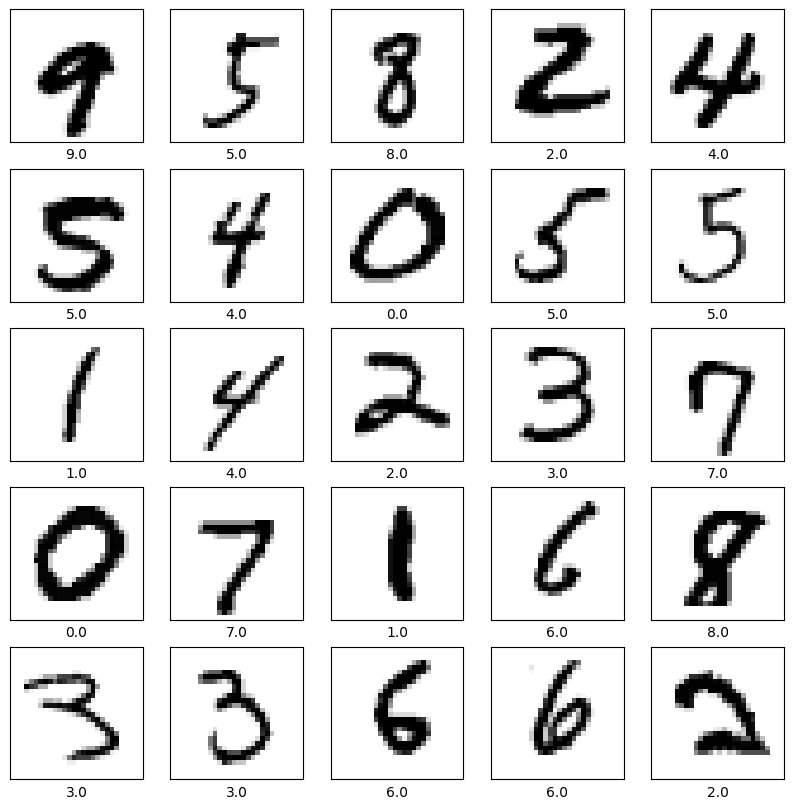

In [4]:
def plot_images_sample(X, Y):
    plt.figure(figsize=(10,10))
    rand_indicies = np.random.randint(len(X), size=25)
    for i in range(25):
        plt.subplot(5,5,i+1)
        plt.xticks([])
        plt.yticks([])
        plt.grid(False)
        index = rand_indicies[i]
        plt.imshow(np.squeeze(X[index]), cmap=plt.cm.binary)
        plt.xlabel(Y[index])
    plt.show()

plot_images_sample(data, labels)

In [5]:
x_train, x_test, y_train, y_test = train_test_split(data, labels, test_size=0.1, shuffle=True)
X_train = x_train / 255.
X_test = x_test / 255.
Y_train = to_categorical(y_train)
Y_test = to_categorical(y_test)

In [6]:
model = models.Sequential([
        layers.Conv2D(8, kernel_size=(4, 4), strides=(1, 1), padding='same', activation='relu', input_shape=data_shape),
        layers.MaxPooling2D((8, 8), padding='same'),
        layers.Conv2D(16, kernel_size=(2, 2), strides=(1, 1), padding='same', activation='relu'),
        layers.MaxPooling2D((4, 4), padding='same'),
        layers.Flatten(),
        layers.Dense(classes_count)
    ])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 28, 28, 8)         136       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 4, 4, 8)          0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 4, 4, 16)          528       
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 1, 1, 16)         0         
 2D)                                                             
                                                                 
 flatten (Flatten)           (None, 16)                0         
                                                                 
 dense (Dense)               (None, 10)                1

In [7]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

history = model.fit(X_train, Y_train, epochs=10, validation_split=0.2)

Epoch 1/10
1575/1575 [==============================] - 16s 9ms/step - loss: 1.0653 - accuracy: 0.6655 - val_loss: 0.5398 - val_accuracy: 0.8371
Epoch 2/10
1575/1575 [==============================] - 14s 9ms/step - loss: 0.4443 - accuracy: 0.8646 - val_loss: 0.3813 - val_accuracy: 0.8876
Epoch 3/10
1575/1575 [==============================] - 14s 9ms/step - loss: 0.3405 - accuracy: 0.8967 - val_loss: 0.3200 - val_accuracy: 0.9047
Epoch 4/10
1575/1575 [==============================] - 14s 9ms/step - loss: 0.2860 - accuracy: 0.9133 - val_loss: 0.2716 - val_accuracy: 0.9193
Epoch 5/10
1575/1575 [==============================] - 14s 9ms/step - loss: 0.2503 - accuracy: 0.9235 - val_loss: 0.2443 - val_accuracy: 0.9283
Epoch 6/10
1575/1575 [==============================] - 14s 9ms/step - loss: 0.2240 - accuracy: 0.9306 - val_loss: 0.2228 - val_accuracy: 0.9326
Epoch 7/10
1575/1575 [==============================] - 14s 9ms/step - loss: 0.2061 - accuracy: 0.9359 - val_loss: 0.1985 - val_ac

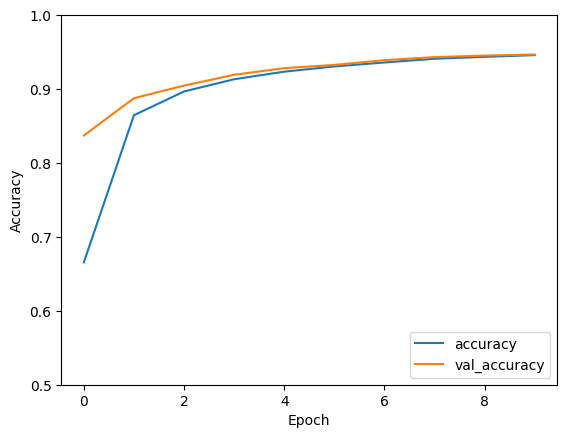

In [8]:
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label='val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.5, 1])
plt.legend(loc='lower right')
plt.show()

In [9]:
test_loss, test_acc = model.evaluate(X_test, Y_test, verbose=2)
print("test accuracy: " + str(test_acc))

219/219 - 1s - loss: 0.1839 - accuracy: 0.9467 - 787ms/epoch - 4ms/step
test accuracy: 0.9467142820358276


219/219 [==============================] - 1s 4ms/step


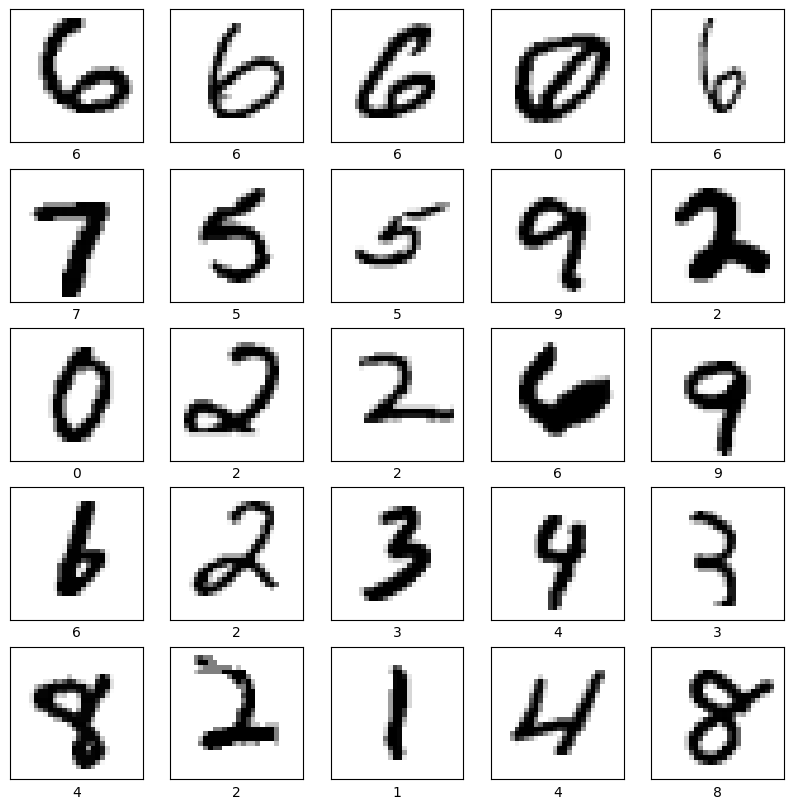

In [10]:
predictions = model.predict(X_test)
predictions = np.argmax(predictions, axis=1)

plot_images_sample(X_test, predictions)

In [11]:
def plot_cm(train, target_train):
    def plot_confusion_matrix(cm, classes,
                              normalize=False,
                              title='Confusion matrix',
                              cmap=plt.cm.Blues):
        plt.imshow(cm, interpolation='nearest', cmap=cmap)
        plt.title(title)
        plt.colorbar()
        tick_marks = np.arange(len(classes))
        plt.xticks(tick_marks, classes, rotation=45)
        plt.yticks(tick_marks, classes)
        
        if normalize:
            cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        
        thresh = cm.max() / 2.
        
        for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
            plt.text(j, i, cm[i, j],
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")

        plt.tight_layout()
        plt.ylabel('True label')
        plt.xlabel('Predicted label')

    # Predict the values from the validation dataset
    Y_pred = model.predict(train)
    # Convert predictions classes to one hot vectors 
    Y_pred_classes = np.argmax(Y_pred,axis = 1) 
    # Convert validation observations to one hot vectors
    Y_true = np.argmax(target_train,axis = 1) 
    # compute the confusion matrix
    confusion_mtx = confusion_matrix(Y_true, Y_pred_classes) 
    # plot the confusion matrix
    plot_confusion_matrix(confusion_mtx, classes = range(10)) 

1969/1969 [==============================] - 7s 4ms/step


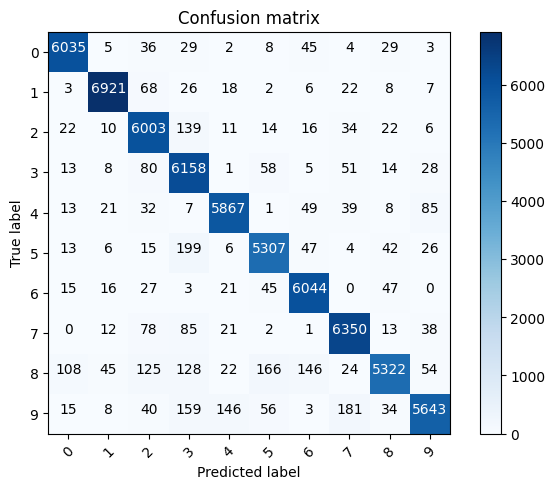

In [12]:
# Draw confusing matrix for training data
plot_cm(X_train, Y_train)

219/219 [==============================] - 1s 4ms/step


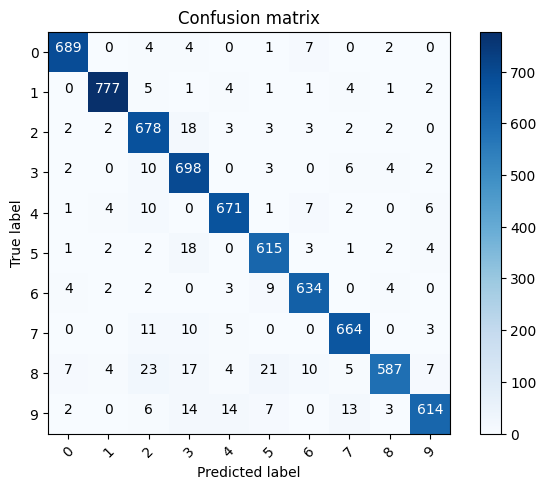

In [13]:
# Draw confusing matrix for test data
plot_cm(X_test, Y_test)

<strong>Report</strong><br>
The MNIST dataset consists of a large collection of handwritten digits. The dataset contains a total of 70,000 samples. Each sample is a grayscale image with dimensions 28x28 pixels. The pixel values range from 0 to 255, representing different shades of gray.<br>
The dataset is split into two main components: the data and the labels. The mnist_data variable represents the data portion of the dataset. It is a numpy array of shape (70000, 28, 28, 1), where the first dimension corresponds to the number of samples, and the remaining dimensions represent the height, width, and depth of each image, respectively.<br>
The mnist_label variable contains the corresponding labels for each sample in the dataset. It is a numpy array of shape (70000,), with each element representing the class label of the corresponding image.<br>
In this dataset, there are 10 classes in total, corresponding to the digits from 0 to 9. The variable classes_count indicates the number of unique classes in the dataset, which is 10 in this case.<br><br>
To prepare the MNIST dataset for training and testing, the dataset is divided into training and testing sets using a 90-10 split.<br>
To ensure that the pixel values are within the range of 0 to 1, the training and testing data are divided by 255. This normalization step scales down the pixel values to the range of 0 to 1, which can improve the training process.<br>
Additionally, the labels are converted to categorical form using the to_categorical function. This step is necessary for multi-class classification tasks, as it transforms the class labels into one-hot encoded vectors. Each one-hot encoded vector has a length equal to the number of classes, and the corresponding index is set to 1 to indicate the class label.<br>
By performing these data preprocessing steps, the MNIST dataset is now ready for training and evaluation.<br><br>
The model consists of several layers:<br>
<strong>Conv2D</strong> layer with 8 filters, a kernel size of (4, 4), and a stride of (1, 1). It uses the ReLU activation function and takes the input shape of data_shape, which is (28, 28, 1) in this case.
<strong>MaxPooling2D</strong> layer with a pool size of (8, 8) and padding set to 'same'.<br>
<strong>Conv2D</strong> layer with 16 filters, a kernel size of (2, 2), and a stride of (1, 1). It also uses the ReLU activation function.<br>
<strong>MaxPooling2D</strong> layer with a pool size of (4, 4) and padding set to 'same'.<br>
<strong>Flatten</strong> layer, which flattens the 2D feature maps into a 1D vector.<br>
<strong>Dense</strong> layer with classes_count units, representing the output layer. This layer does not have an activation function specified, as it will be determined based on the classification task .<br>
By incorporating Conv2D layers in the MLP neural network architecture, the model can effectively extract relevant features from the input images and leverage their spatial relationships to improve classification performance.<br>
The inclusion of MaxPooling2D layers provides benefits such as dimensionality reduction, translation invariance, robustness to noise, and hierarchical feature learning.<br>
By including the Flatten layer, the model can effectively transition from the convolutional layers to the fully connected layers, transform the spatially structured information into a feature vector representation, consider global context, and improve parameter efficiency.<br>
finally The Dense layer is often used as the output layer in classification tasks. The number of neurons in the output layer matches the number of classes in the dataset. <br><br>
The Adam optimizer is chosen as the optimizer for training the model. Adam is a popular optimization algorithm that combines the advantages of both AdaGrad and RMSProp, providing efficient and adaptive updates to the model weights during training.<br>
Categorical Crossentropy loss function is selected for this multi-class classification task. The model's output does not have a softmax activation applied, and the raw logits are used as inputs to the loss function.<br>
The accuracy metric is used to evaluate the performance of the model during training and validation.<br>
The number of epochs is set to 10 and the training dataset is further split into a validation set to monitor the model's performance during training. Here, 20% of the training data is allocated for validation.<br><br>

<h2>Question 2</h2>
The given figure demonstrates a training dataset that contains two classes. Use the K-nearest neighbors(KNN) method to calculate the leave-one-out cross-validation error for k=1 and k=3.

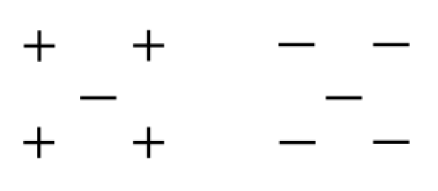

<h2>Answer</h2>
k=1 :

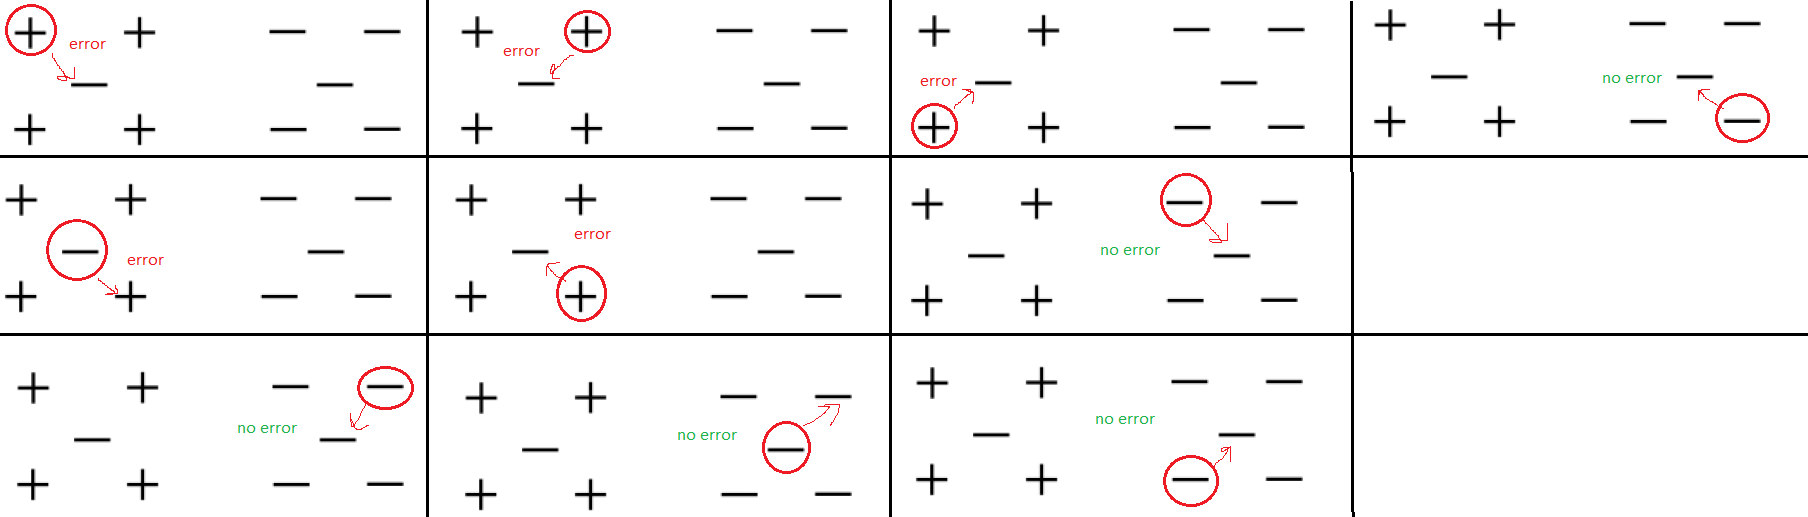

in the case of k=1 we have 5 error out of 10 samples.<br><br>
k=3:

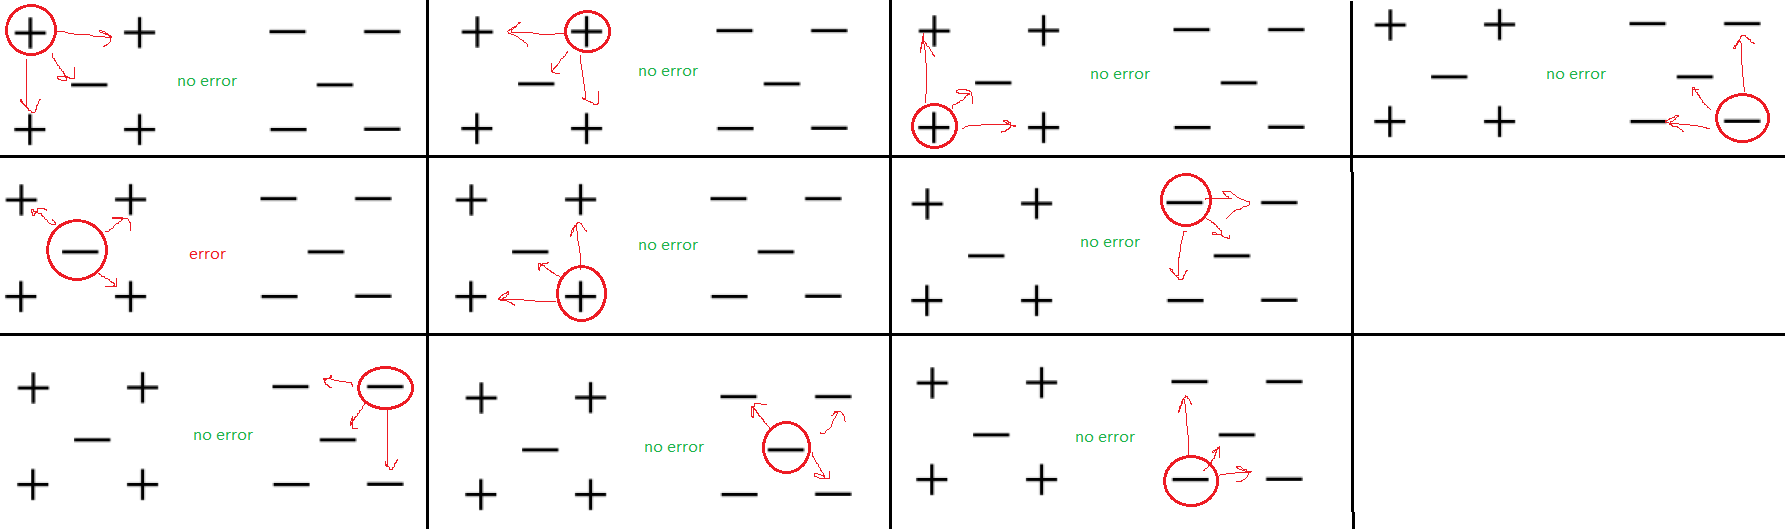

in the case of k = 3 we have 1 error out of 10 samples.

<h2>Question 3</h2>
Fill the provided table using the IRIS dataset. Employ 4-fold cross-validation for assessment. Describe the results and dispersion accuracy of each method in a paragraph.

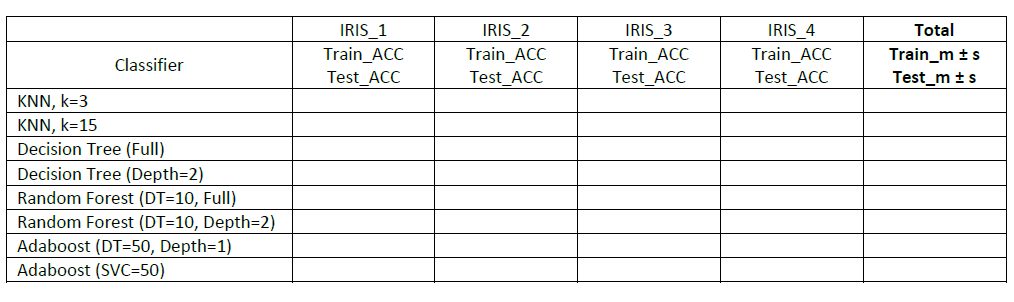

In [14]:
iris = datasets.load_iris()
iris_X = iris.data
iris_y = iris.target

In [15]:
clfs = [{"clfType": KNeighborsClassifier(n_neighbors = 3), "name": "KNN, k=3"},
        {"clfType": KNeighborsClassifier(n_neighbors = 15), "name": "KNN, k=15"},
        {"clfType": DecisionTreeClassifier(), "name": "DT (Full)"},
        {"clfType": DecisionTreeClassifier(max_depth = 2), "name": "DT (Depth=2)"},
        {"clfType": RandomForestClassifier(n_estimators = 10), "name": "RF (DT=10, Full)"},
        {"clfType": RandomForestClassifier(n_estimators = 10, max_depth = 2), "name": "RF (DT=10, Depth=2)"},
        {"clfType": AdaBoostClassifier(DecisionTreeClassifier(max_depth=1), n_estimators = 50), "name": "AB (DT=50, Depth=1)"},
        {"clfType": AdaBoostClassifier(SVC(probability=True), n_estimators=50), "name": "AB (SVC=50)"},
       ]

In [16]:
scores = []
for clf in clfs:
    score = cross_validate(clf["clfType"], iris_X, iris_y, scoring='accuracy', cv=4, return_train_score=True)
    scores.append(score)

In [17]:
print("\t\t\t| IRIS 1\t\t| IRIS 2\t\t| IRIS 3\t\t| IRIS 4\t\t| Total")
print("====================================================================================================================================================")
print("\tclassifier\t|TrainAcc, TestAcc\t|TrainAcc, TestAcc\t|TrainAcc, TestAcc\t|TrainAcc, TestAcc\t|Train_m+-s, Test_m+-s\t")
print("====================================================================================================================================================")
for i in range(len(clfs)):
    if (i<4 or i==7):
        print(clfs[i]["name"],"\t\t|","%.2f" %scores[i]['train_score'][0],", %.2f" %scores[i]['test_score'][0],"\t\t|"
              ,"%.2f" %scores[i]['train_score'][1],", %.2f" %scores[i]['test_score'][1],"\t\t|"
               ,"%.2f" %scores[i]['train_score'][2],", %.2f" %scores[i]['test_score'][2],"\t\t|"
                ,"%.2f" %scores[i]['train_score'][3],", %.2f" %scores[i]['test_score'][3],"\t\t|"
                 ,"%.2f" %scores[i]['train_score'].mean(), "+-","%.2f" %scores[i]['train_score'].std(),", "
                 ,"%.2f" %scores[i]['test_score'].mean(), "+-","%.2f" %scores[i]['test_score'].std())
    else:
        print(clfs[i]["name"],"\t|","%.2f" %scores[i]['train_score'][0],", %.2f" %scores[i]['test_score'][0],"\t\t|"
              ,"%.2f" %scores[i]['train_score'][1],", %.2f" %scores[i]['test_score'][1],"\t\t|"
              ,"%.2f" %scores[i]['train_score'][2],", %.2f" %scores[i]['test_score'][2],"\t\t|"
              ,"%.2f" %scores[i]['train_score'][3],", %.2f" %scores[i]['test_score'][3],"\t\t|"
              ,"%.2f" %scores[i]['train_score'].mean(), "+-","%.2f" %scores[i]['train_score'].std(),", "
                 ,"%.2f" %scores[i]['test_score'].mean(), "+-","%.2f" %scores[i]['test_score'].std())

			| IRIS 1		| IRIS 2		| IRIS 3		| IRIS 4		| Total
	classifier	|TrainAcc, TestAcc	|TrainAcc, TestAcc	|TrainAcc, TestAcc	|TrainAcc, TestAcc	|Train_m+-s, Test_m+-s	
KNN, k=3 		| 0.96 , 0.97 		| 0.98 , 0.95 		| 0.96 , 0.92 		| 0.96 , 1.00 		| 0.96 +- 0.01 ,  0.96 +- 0.03
KNN, k=15 		| 0.98 , 0.95 		| 0.98 , 1.00 		| 0.99 , 0.95 		| 0.96 , 0.97 		| 0.98 +- 0.01 ,  0.97 +- 0.02
DT (Full) 		| 1.00 , 0.97 		| 1.00 , 0.95 		| 1.00 , 0.95 		| 1.00 , 1.00 		| 1.00 +- 0.00 ,  0.97 +- 0.02
DT (Depth=2) 		| 0.96 , 0.95 		| 0.96 , 0.95 		| 0.98 , 0.89 		| 0.95 , 1.00 		| 0.96 +- 0.01 ,  0.95 +- 0.04
RF (DT=10, Full) 	| 0.99 , 0.97 		| 1.00 , 0.95 		| 0.99 , 0.95 		| 1.00 , 0.97 		| 1.00 +- 0.00 ,  0.96 +- 0.01
RF (DT=10, Depth=2) 	| 0.97 , 0.97 		| 0.96 , 0.95 		| 0.98 , 0.95 		| 0.94 , 1.00 		| 0.96 +- 0.02 ,  0.97 +- 0.02
AB (DT=50, Depth=1) 	| 0.95 , 0.97 		| 0.97 , 0.95 		| 0.99 , 0.95 		| 0.95 , 1.00 		| 0.96 +- 0.02 ,  0.97 +- 0.02
AB (SVC=50) 		| 0.95 , 0.97 		| 0.96 , 0.97 		| 1.00 , 0.95 		

<strong>results</strong><br>
Upon analyzing the results, it is evident that Adaboost, which consists of multiple weak learners, achieves the best overall performance among all classifiers while also demonstrating the lowest variance. Notably, Adaboost consistently performs well on both the train and test sets, indicating a reliable and consistent estimation. KNN, on the other hand, exhibits low bias and provides reasonably accurate estimations. However, its variance in the test sets is comparatively higher than most other classifiers, suggesting a higher variability in performance. Among the classifiers, decision trees exhibit the most accurate estimations on the train sets. However, their performance on the test sets is notably lower, indicating a lower generalization capability. Specifically, the decision tree with a depth of 2 shows the highest variance among the classifiers. Random forests, while improving upon decision trees, still maintain a low bias estimation. They effectively reduce the variance compared to individual decision trees, enhancing the overall performance and reducing overfitting.

<h2>Question 4</h2>
Split the Iris dataset randomly with a 70-30 ratio into a train and test set. Assess the accuracy of the train and test results for every combination of two features (feature selection) and a single PCA combination of 2 features (feature projection) using the given classifier in the table. Plot the results as a 2D graph representing the classes. Finally, provide an analysis of the effect of the selected features on classification accuracy in a paragraph.

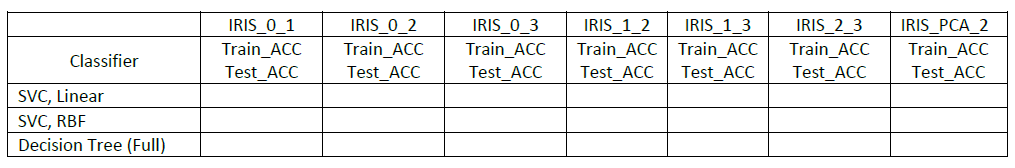

In [18]:
iris_x_train, iris_x_test, iris_y_train, iris_y_test = train_test_split(iris_X, iris_y, test_size=0.3, random_state=1)
clfs2 = [{"clfType": SVC(kernel='linear', C=0.1), "name": "SVM Linear"},
        {"clfType": SVC(C=0.1), "name": "SVM RBF"},
        {"clfType": DecisionTreeClassifier(), "name": "DT (Full)"},
       ]

In [19]:
X_train_reduced = PCA(n_components=2).fit_transform(iris_x_train) #PCA
X_test_reduced = PCA(n_components=2).fit_transform(iris_x_test) #PCA
pca_results = []
for clf in clfs2:
    result = []
    clf["clfType"].fit(iris_x_train[:, :2], iris_y_train)#0,1
    result.append(clf["clfType"].score(iris_x_test[:, :2],iris_y_test))
    result.append(clf["clfType"].score(iris_x_train[:, :2],iris_y_train))

    clf["clfType"].fit(iris_x_train[:, ::2], iris_y_train)#0,2
    result.append(clf["clfType"].score(iris_x_test[:, ::2],iris_y_test))
    result.append(clf["clfType"].score(iris_x_train[:, ::2],iris_y_train))

    clf["clfType"].fit(iris_x_train[:, ::3], iris_y_train)#0,3
    result.append(clf["clfType"].score(iris_x_test[:, ::3],iris_y_test))
    result.append(clf["clfType"].score(iris_x_train[:, ::3],iris_y_train))

    clf["clfType"].fit(iris_x_train[:, 1:3], iris_y_train)#1,2
    result.append(clf["clfType"].score(iris_x_test[:, 1:3],iris_y_test))
    result.append(clf["clfType"].score(iris_x_train[:, 1:3],iris_y_train))

    clf["clfType"].fit(iris_x_train[:, 1::2], iris_y_train)#1,3
    result.append(clf["clfType"].score(iris_x_test[:, 1::2],iris_y_test))
    result.append(clf["clfType"].score(iris_x_train[:, 1::2],iris_y_train))

    clf["clfType"].fit(iris_x_train[:, 2:4:], iris_y_train)#2,3
    result.append(clf["clfType"].score(iris_x_test[:, 2:4:],iris_y_test))
    result.append(clf["clfType"].score(iris_x_train[:, 2:4:],iris_y_train))

    clf["clfType"].fit(X_train_reduced, iris_y_train)#PCA
    result.append(clf["clfType"].score(X_test_reduced,iris_y_test))
    result.append(clf["clfType"].score(X_train_reduced,iris_y_train))
    pca_results.append(result)


In [20]:
print("\t\t\t| IRIS 01\t\t| IRIS 02\t\t| IRIS 03\t\t| IRIS 12\t\t| IRIS 13\t\t| IRIS 23\t\t| IRIS PCA")
print("===========================================================================================================================================================================================")
print("\tclassifier\t|TrainAcc, TestAcc\t|TrainAcc, TestAcc\t|TrainAcc, TestAcc\t|TrainAcc, TestAcc\t|TrainAcc, TestAcc\t|TrainAcc, TestAcc\t|TrainAcc, TestAcc")
print("===========================================================================================================================================================================================")
for i in range(len(clfs2)):
        print(clfs2[i]["name"],"\t\t|%.2f" %pca_results[i][1],"%.2f" %pca_results[i][0] , "\t\t|%.2f" %pca_results[i][3],"%.2f" %pca_results[i][2] ,
              "\t\t|%.2f" %pca_results[i][5],"%.2f" %pca_results[i][4], "\t\t|%.2f" %pca_results[i][7],"%.2f" %pca_results[i][6],
              "\t\t|%.2f" %pca_results[i][9],"%.2f" %pca_results[i][8], "\t\t|%.2f" %pca_results[i][11],"%.2f" %pca_results[i][10],
              "\t\t|%.2f" %pca_results[i][13],"%.2f" %pca_results[i][12])

			| IRIS 01		| IRIS 02		| IRIS 03		| IRIS 12		| IRIS 13		| IRIS 23		| IRIS PCA
	classifier	|TrainAcc, TestAcc	|TrainAcc, TestAcc	|TrainAcc, TestAcc	|TrainAcc, TestAcc	|TrainAcc, TestAcc	|TrainAcc, TestAcc	|TrainAcc, TestAcc
SVM Linear 		|0.82 0.76 		|0.94 0.98 		|0.92 0.91 		|0.94 0.98 		|0.95 0.93 		|0.97 0.98 		|0.95 0.98
SVM RBF 		|0.70 0.60 		|0.92 0.98 		|0.69 0.60 		|0.94 0.98 		|0.93 0.91 		|0.95 0.98 		|0.92 0.98
DT (Full) 		|0.95 0.62 		|0.99 0.96 		|0.97 0.96 		|0.98 0.98 		|1.00 0.91 		|0.99 0.96 		|1.00 0.98


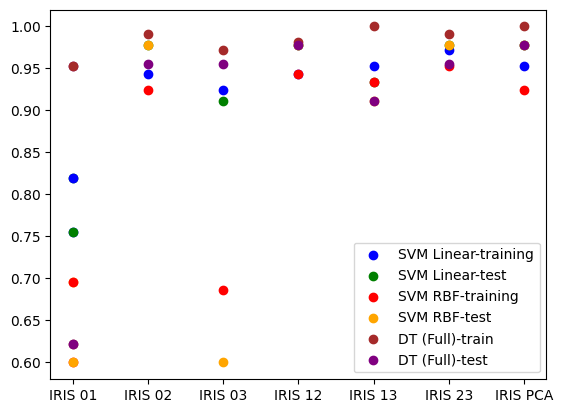

In [21]:
iris_labels = [{"name":'IRIS 01', "num":1},{"name":'IRIS 02', "num":2},{"name":'IRIS 03', "num":3},{"name":'IRIS 12', "num":4},{"name":'IRIS 13', "num":5},
               {"name":'IRIS 23', "num":6},{"name":'IRIS PCA', "num":7}]
plt.scatter(iris_labels[0]["name"],pca_results[0][0], c = "b", label='SVM Linear-training')
plt.scatter(iris_labels[0]["name"],pca_results[0][1], c = "g", label='SVM Linear-test')

plt.scatter(iris_labels[0]["name"],pca_results[1][0], c = "r", label='SVM RBF-training')
plt.scatter(iris_labels[0]["name"],pca_results[1][1], c = "orange", label='SVM RBF-test')

plt.scatter(iris_labels[0]["name"],pca_results[2][0], c = "brown", label='DT (Full)-train')
plt.scatter(iris_labels[0]["name"],pca_results[2][1], c = "purple", label='DT (Full)-test')
for label in iris_labels:
    plt.scatter(label["name"],pca_results[0][2*label["num"]-1], c = "b")
    plt.scatter(label["name"],pca_results[0][2*label["num"]-2], c = "g")
    
    plt.scatter(label["name"],pca_results[1][2*label["num"]-1], c = "r")
    plt.scatter(label["name"],pca_results[1][2*label["num"]-2], c = "orange")

    plt.scatter(label["name"],pca_results[2][2*label["num"]-1], c = "brown")
    plt.scatter(label["name"],pca_results[2][2*label["num"]-2], c = "purple")
    
plt.legend()
plt.show()

<h2>result</h2>
Analyzing the plot, it becomes evident that DT exhibits the best predictions on the training sets. However, its higher variance leads to worse predictions compared to SVM RBF and SVM Linear. In some cases, points are overlayed.<br>
Combinations of features 0 and 1, as well as features 0 and 3, result in poor performance. Conversely, PCA  and combinations of features 1 and 2 and combinations of features 2 and 3 demonstrate the best performance on the test set. These feature combinations showcase the strongest impact on accurate classification.On the other hand, we can say that feature 0 has the least impact on classification accuracy. Also features 1 and 3 display a moderate impact on the final results.

<h2>Question 5</h2>
Utilize the K-means method to cluster the IRIS dataset. Analyze the convergence process(by the value of J) for k values of 2, 3, 4, and 5. Assess the final results using silhouette score and NMI metrics and confusion matrix.

<h2>Answer</h2>

In [22]:
iris_X_c = iris.data
iris_y_c = iris.target

In [23]:
wcss = []
sil_scores = []
NMI_scores = []
CM_scores = []
for i in range(2, 6):
    kmeans = KMeans(n_clusters = i,init = 'random', n_init = 10, random_state = 1)
    kmeans.fit(iris_X_c)
    cluster_labels = kmeans.predict(iris_X_c)
    
    sil_scores.append(silhouette_score(iris_X_c, cluster_labels))
    NMI_scores.append(normalized_mutual_info_score(iris_y_c,cluster_labels))
    CM_scores.append(pair_confusion_matrix(iris_y_c, cluster_labels))
    
    wcss.append(kmeans.inertia_)

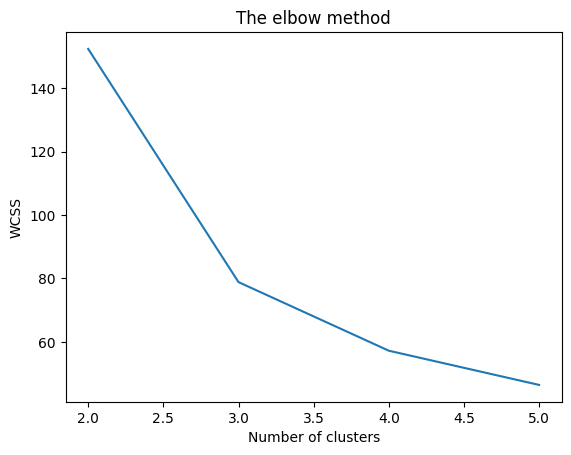

In [24]:
plt.plot(range(2, 6), wcss)
plt.title('The elbow method')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')
plt.show()

We can observe that as the number of clusters increases, the convergence process continues without showing signs of flattening.

In [25]:
for i in range(4):
    print("k =", i+2,":")
    print("\tsilhouette score:",sil_scores[i])
    print("\tNMI score:",NMI_scores[i])
    print("\tConfusion matrix:\n\t\t\t|",CM_scores[i][0][0],"   ",CM_scores[i][0][1],"|\n\t\t\t|",CM_scores[i][1][0],"    ",CM_scores[i][1][1],"|")

k = 2 :
	silhouette score: 0.6810461692117462
	NMI score: 0.6565191143081124
	Confusion matrix:
			| 10000     5000 |
			| 282      7068 |
k = 3 :
	silhouette score: 0.5528190123564095
	NMI score: 0.7581756800057784
	Confusion matrix:
			| 13512     1488 |
			| 1200      6150 |
k = 4 :
	silhouette score: 0.49805050499728737
	NMI score: 0.7219203867820961
	Confusion matrix:
			| 14164     836 |
			| 2428      4922 |
k = 5 :
	silhouette score: 0.48874888709310566
	NMI score: 0.6938628345588717
	Confusion matrix:
			| 14276     724 |
			| 2858      4492 |


<strong>silhouette score: </strong> We can observe that increasing number of clusters, reduces the silhouette score. It means that k=2 is the best choice and k=5 is the worst choice considering silhouette score<br>
<strong>NMI score: </strong>NMI scores suggest that k=3 provides the best model according to original labels and k=2 provides the worst model.<br>
<strong>Confusion matrix: </strong>Confusion matrix shows that we have the least misclassified samples in k=4 clustering and most misclassified samples in k=2. so k=4 is the best model and k=2 is the worst model considering Confusion matrix<br>